<a href="https://colab.research.google.com/github/sladem-tox/Rdkit-stuff/blob/main/Drug_Checker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Let's have a look at drugs!

Take a few smiles structures for common drugs and we will have a look at them together. 

1.   Draw them
2.   Count their features
1.   Check with Chris!!




In [ ]:
!pip install rdkit 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 39.4 MB/s eta 0:00:00


In [ ]:
smiles_list = ['CC(C)C1=C(C(=C(N1CC[C@H](C[C@H](CC(=O)O)O)O)C2=CC=C(C=C2)F)C3=CC=CC=C3)C(=O)NC4=CC=CC=C4', 'CCOC1=NC2=CC=CC(=C2N1CC3=CC=C(C=C3)C4=CC=CC=C4C5=NNN=N5)C(=O)O', 
               'O=C([C@H](CC1=CNC=N1)N)O', 'C([C@@H](C(=O)O)N)S', 'CCCS(=O)(=O)Nc1ccc(F)c(c1F)C(=O)c2c[nH]c3c2cc(cn3)c4ccc(Cl)cc4','O=C(C)Oc1ccccc1C(=O)O', 'OC(=O)c1ccccc1C([O-])=O']

## Now let's draw them!

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
mol_list = []
for smiles in smiles_list:
  mol = Chem.MolFromSmiles(smiles)
  mol_list.append(mol)
  img = Draw.MolsToGridImage(mol_list, molsPerRow=4)


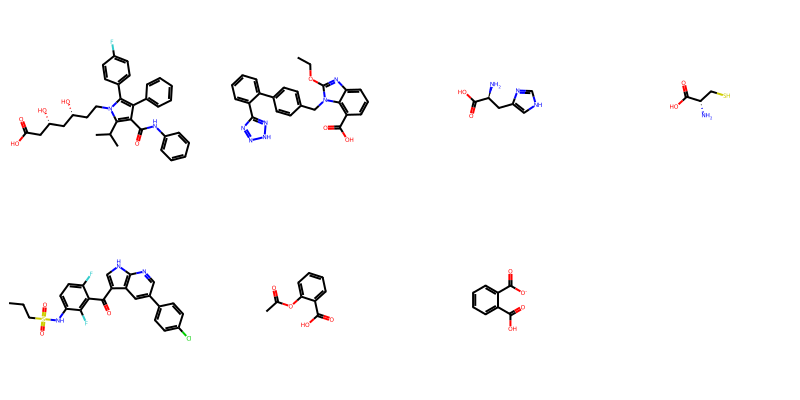

In [ ]:
img

In [ ]:
# Get the chemical name from PubChem
# First we create this function to search Pubchem for the chemical name based on our smiles structure
import requests

def get_compound_name(smiles):
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/{smiles}/property/IUPACName/TXT"
    response = requests.get(url)
    if response.status_code == 200:
        return response.text.strip()
    else:
        return None



In [ ]:
# Next we pass one of our smiles structures from the list above to the chemical naming function.
smiles = smiles_list[0]
name = get_compound_name(smiles)
print(name)

(3R,5R)-7-[2-(4-fluorophenyl)-3-phenyl-4-(phenylcarbamoyl)-5-propan-2-ylpyrrol-1-yl]-3,5-dihydroxyheptanoic acid


In [ ]:
# The chemical name (IUPAC format) is not very enlightening!
# So here is another function, this time to look in PubMed
import requests
from xml.etree import ElementTree

def get_compound_info(smiles):
    # Get IUPAC name
    iupac_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/{smiles}/property/IUPACName/TXT"
    iupac_response = requests.get(iupac_url)
    iupac_name = iupac_response.text.strip() if iupac_response.status_code == 200 else None
    
    # Get drug name (if available)
    drug_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/{smiles}/xrefs/PubMedID/TXT"
    drug_response = requests.get(drug_url)
    drug_name = None
    if drug_response.status_code == 200:
        pubmed_ids = [id.strip() for id in drug_response.text.strip().split("\n")]
        for pubmed_id in pubmed_ids:
            article_url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&id={pubmed_id}&retmode=xml"
            article_response = requests.get(article_url)
            if article_response.status_code == 200:
                tree = ElementTree.fromstring(article_response.content)
                title_elem = tree.find(".//ArticleTitle")
                if title_elem is not None:
                    drug_name = title_elem.text.strip()
                    break
    
    return {"IUPAC": iupac_name, "Drug": drug_name}



In [ ]:
# Next we pass one of our smiles structures from the list above to our PubMed search function to see if it is a drug.
# This method is not perfect because some articles it finds don't mention the drug name!
smiles = smiles_list[4]
info = get_compound_info(smiles)
print(info)

{'IUPAC': 'N-[3-[5-(4-chlorophenyl)-1H-pyrrolo[2,3-b]pyridine-3-carbonyl]-2,4-difluorophenyl]propane-1-sulfonamide', 'Drug': 'Clinical efficacy of a RAF inhibitor needs broad target blockade in BRAF-mutant melanoma.'}


## Now let's get some more general information about the molecules. Let's count their atoms and rings!

In [ ]:
from rdkit import Chem

def count_atoms_and_rings(smiles_list):
    results = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)

        num_carbons = len(mol.GetSubstructMatches(Chem.MolFromSmarts("[#6]")))
        num_nitrogens = len(mol.GetSubstructMatches(Chem.MolFromSmarts("[#7]")))
        num_oxygens = len(mol.GetSubstructMatches(Chem.MolFromSmarts("[#8]")))
        num_halogens = len(mol.GetSubstructMatches(Chem.MolFromSmarts("[#9,#17,#35,#53]")))
        num_rings = len(Chem.GetSymmSSSR(mol))

        result = {"smiles": smiles, "Carbons": num_carbons, "Nitrogens": num_nitrogens, 
                  "Oxygens": num_oxygens, "Halogens": num_halogens, "Rings": num_rings}
        results.append(result)
    return results


In [ ]:
count_atoms_and_rings(smiles_list)

[{'smiles': 'CC(C)C1=C(C(=C(N1CC[C@H](C[C@H](CC(=O)O)O)O)C2=CC=C(C=C2)F)C3=CC=CC=C3)C(=O)NC4=CC=CC=C4',
  'Carbons': 33,
  'Nitrogens': 2,
  'Oxygens': 5,
  'Halogens': 1,
  'Rings': 4},
 {'smiles': 'CCOC1=NC2=CC=CC(=C2N1CC3=CC=C(C=C3)C4=CC=CC=C4C5=NNN=N5)C(=O)O',
  'Carbons': 24,
  'Nitrogens': 6,
  'Oxygens': 3,
  'Halogens': 0,
  'Rings': 5},
 {'smiles': 'O=C([C@H](CC1=CNC=N1)N)O',
  'Carbons': 6,
  'Nitrogens': 3,
  'Oxygens': 2,
  'Halogens': 0,
  'Rings': 1},
 {'smiles': 'C([C@@H](C(=O)O)N)S',
  'Carbons': 3,
  'Nitrogens': 1,
  'Oxygens': 2,
  'Halogens': 0,
  'Rings': 0},
 {'smiles': 'CCCS(=O)(=O)Nc1ccc(F)c(c1F)C(=O)c2c[nH]c3c2cc(cn3)c4ccc(Cl)cc4',
  'Carbons': 23,
  'Nitrogens': 3,
  'Oxygens': 3,
  'Halogens': 3,
  'Rings': 4}]

## Do they pass Lipinski's Rule of Five?

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors

def check_lipinski_rule(smiles_list):
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        violations = []
        if Descriptors.MolWt(mol) > 500:
            violations.append('molecular weight > 500')
        if Descriptors.NumHAcceptors(mol) > 10:
            violations.append('number of hydrogen bond acceptors > 10')
        if Descriptors.NumHDonors(mol) > 5:
            violations.append('number of hydrogen bond donors > 5')
        if Descriptors.MolLogP(mol) > 5:
            violations.append('logP > 5')
        if violations:
            print(f"SMILES '{smiles}' fails Lipinski's Rule of Five due to the following reasons: {', '.join(violations)}")
        else:
            print(f"SMILES '{smiles}' passes Lipinski's Rule of Five.")


In [ ]:
check_lipinski_rule(smiles_list)

SMILES 'CC(C)C1=C(C(=C(N1CC[C@H](C[C@H](CC(=O)O)O)O)C2=CC=C(C=C2)F)C3=CC=CC=C3)C(=O)NC4=CC=CC=C4' fails Lipinski's Rule of Five due to the following reasons: molecular weight > 500, logP > 5
SMILES 'CCOC1=NC2=CC=CC(=C2N1CC3=CC=C(C=C3)C4=CC=CC=C4C5=NNN=N5)C(=O)O' passes Lipinski's Rule of Five.
SMILES 'O=C([C@H](CC1=CNC=N1)N)O' passes Lipinski's Rule of Five.
SMILES 'C([C@@H](C(=O)O)N)S' passes Lipinski's Rule of Five.
SMILES 'CCCS(=O)(=O)Nc1ccc(F)c(c1F)C(=O)c2c[nH]c3c2cc(cn3)c4ccc(Cl)cc4' fails Lipinski's Rule of Five due to the following reasons: logP > 5
